In [33]:
import numpy as np
import pandas as pd
from pandas.core.common import SettingWithCopyWarning

import warnings
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold

import lightgbm as lgb
import matplotlib.pyplot as plt
import time
import seaborn as sns
from tqdm import tqdm as tqdm

In [34]:
f2 = pd.read_pickle('features/progress2.pkl')
f3 = pd.read_pickle('features/progress3.pkl')
f4 = pd.read_pickle('features/progress4.pkl')
#f5 = pd.read_pickle('features/progress5.pkl')

In [35]:
print(f2.shape,f3.shape,f4.shape)

(2216160, 18) (2216160, 20) (2216160, 12)


In [36]:
# 合并特征
filelist = [f2,f3,f4]
f = pd.DataFrame()
for file in tqdm(filelist):
    for c in file.columns:
        if c in f.columns:continue
        f[c] = list(file[c])

100%|██████████| 3/3 [00:18<00:00,  7.00s/it]


In [37]:
# 补充周几 7-1 8-2
f['weekday'] = (f['date']-7)%7+1

In [38]:
cycle = f[f.date==7].shape[0]
print(cycle)
label = list(f['count_10min_bystation'])[cycle:]+[-1]*cycle
f['label'] = label

116640


In [47]:
f = f[f.stationID!=54]
# f = f[f.minute.isin(set(range(144)))]
# valid traing set
train = f[(f.label!=-1)&(f.weekday<5)&(f.date<19)]
valid = f[(f.date==21)&(f.minute.isin(set(range(144))))]

In [48]:
print(f.columns)

Index(['minute', 'stationID', 'count_10min_all', 'count_30min_all',
       'count_2h_all', 'count_24h_all', 'count_10min_bystation',
       'count_30min_bystation', 'count_2h_bystation', 'count_24h_bystation',
       'count_24h_byminute', 'count_10min_near', 'count_30min_near',
       'count_2h_near', 'count_24h_near', 'week_th', 'weekday', 'date',
       'median_30min_bystation', 'max_count_ID', 'count_10_max', 'device_num',
       'near_num', 'type_0_bystatiommin', 'type_1_bystatiommin',
       'type_2_bystatiommin_x', 'type_2_bystatiommin_y', 'type_0_bystatiom',
       'type_1_bystatiom', 'type_2_bystatiom', 'type_3_bystatiom',
       'type_0_bymin', 'type_1_bymin', 'type_2_bymin', 'type_3_bymin',
       'once_come_by_s_m', 'twice_come_by_s_m', 'twice_to_once_come_s_m',
       'once_come_by_s', 'twice_come_by_s', 'twice_to_once_come_s',
       'once_come_by_m', 'twice_come_by_m', 'twice_to_once_come_m', 'label'],
      dtype='object')


In [49]:
predictor = [x for x in train.columns if x not in ['minute','stationID','label']]

In [62]:
# 给周一到周五的数据的权重依次下降
weight = train['weekday'].apply(lambda x:{1:1,2:0.9,3:0.8,4:0.7}[x])

In [51]:
param = {'num_leaves': 32,
         'min_data_in_leaf': 5, 
         'objective':'mae',
         'max_depth': 5,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'mae',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [63]:
trn_data = lgb.Dataset(train[predictor],label=train['label'],weight=weight)
val_data = lgb.Dataset(valid[predictor],label=valid['label'])

In [59]:
valid_test.shape

(115200, 45)

In [60]:
# 平移法
for i in range(7,26):
    valid_test = f[f.date==i]
    from sklearn.metrics import mean_absolute_error as mae
    print(mae(valid_test['label'],valid_test['count_10min_bystation']))

2.558715277777778
2.393854166666667
2.4598958333333334
3.41546875
8.402309027777777
3.9053472222222223
9.69203125
2.720138888888889
2.6383159722222222
2.589166666666667
3.3975347222222223
8.076493055555556
3.6809895833333335
9.494322916666667
2.6540625
2.7012847222222223
2.7206597222222224
2.985295138888889
23.371180555555554


In [65]:
num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [trn_data, val_data],
                verbose_eval=100,
                early_stopping_rounds = 200)

fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = predictor
fold_importance_df["importance"] = clf.feature_importance()
# valid all 11.7
# valid range(144) 11.4

Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 2.34768	valid_1's l1: 11.7997
[200]	training's l1: 2.31009	valid_1's l1: 11.7196
[300]	training's l1: 2.29939	valid_1's l1: 11.681
[400]	training's l1: 2.29187	valid_1's l1: 11.6589
[500]	training's l1: 2.27974	valid_1's l1: 11.6326
[600]	training's l1: 2.27213	valid_1's l1: 11.6149
[700]	training's l1: 2.2601	valid_1's l1: 11.5947
[800]	training's l1: 2.24649	valid_1's l1: 11.5601
[900]	training's l1: 2.23577	valid_1's l1: 11.5417
[1000]	training's l1: 2.21749	valid_1's l1: 11.5159
[1100]	training's l1: 2.18543	valid_1's l1: 11.4976
[1200]	training's l1: 2.16916	valid_1's l1: 11.4827
[1300]	training's l1: 2.1437	valid_1's l1: 11.4577
[1400]	training's l1: 2.1226	valid_1's l1: 11.4637
Early stopping, best iteration is:
[1284]	training's l1: 2.14902	valid_1's l1: 11.4527


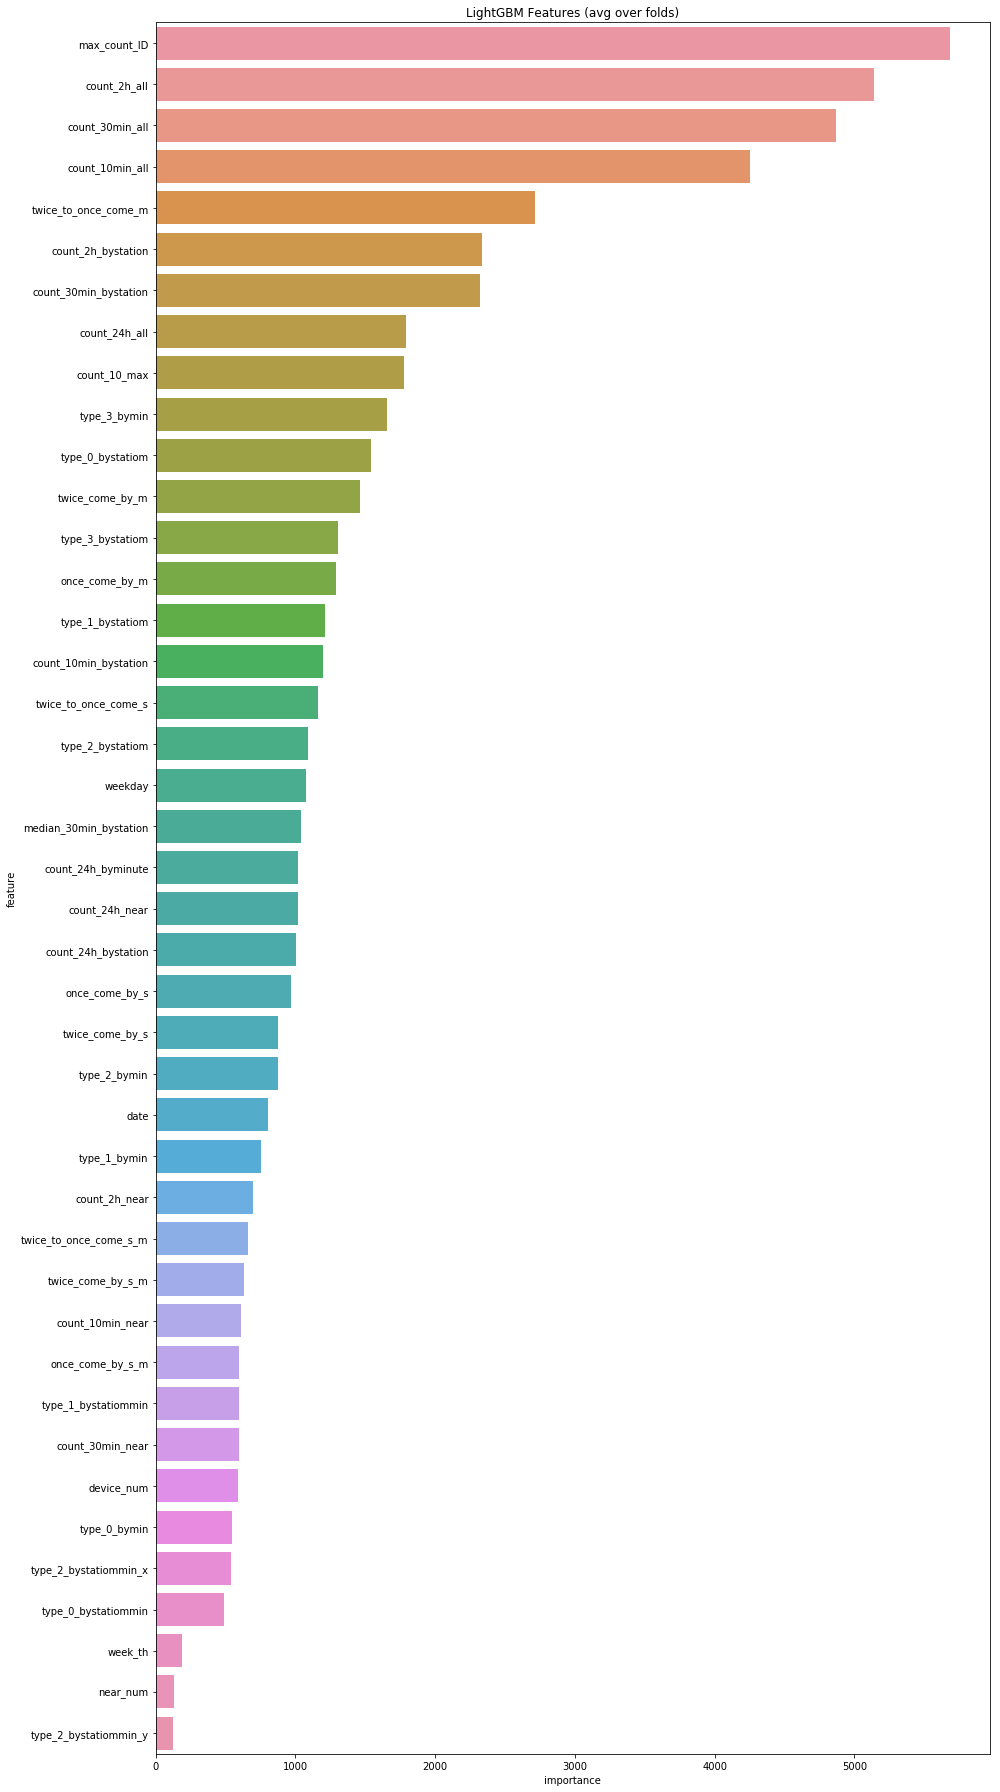

In [56]:
cols = (fold_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = fold_importance_df.loc[fold_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')